# Data Loading

### Loading the Exoplanet training data

The exoplanet training data has already been separated into X_train, X_test, y_train, y_test. 

We will use it for the training


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [68]:
# X_train = np.loadtxt('middle_data/X_train.txt', delimiter=' ')
# X_test  = np.loadtxt('middle_data/X_test.txt', delimiter=' ')

# Y_train = np.loadtxt('middle_data/Y_train.txt', delimiter=' ')
# Y_test  = np.loadtxt('middle_data/Y_test.txt', delimiter=' ')

data = np.loadtxt('planet.txt', delimiter=',', dtype=float)
data.shape

(7400, 38)

In [69]:
X_train = data[:2000, :-1]
Y_train = data[:2000, -1]

X_test = data[2000:3000, :-1]
Y_test = data[2000:3000, -1]


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (2000, 37)
X_test shape: (1000, 37)
Y_train shape: (2000,)
Y_test shape: (1000,)


In [70]:
print(type(X_train))

<class 'numpy.ndarray'>


### 1. Data pre-processing 

In this step, we will perform normalization of the X dataset, and label y in binary terms

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# # Dimensionality reduction
# pca = PCA(n_components=2)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Normalize data to the range [-1, 1] (use the training set to fit the scaler)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure labels are binary (if not already binary)
Y_train = (Y_train > np.median(Y_train)).astype(int)
Y_test = (Y_test > np.median(Y_test)).astype(int)

print(f"X_train shape after selection: {X_train.shape}")
print(f"X_test shape after selection: {X_test.shape}")

X_train shape after selection: (2000, 37)
X_test shape after selection: (1000, 37)


In [72]:
Y_train.shape

(2000,)

# Building MLP model

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [74]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Hyperparameters
batch_size = 32
learning_rate = 0.0001
epochs = 30
num_classes = 2
input_size = 37

In [75]:
# Building dataset 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)  
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long)  
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [76]:
# Creating MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        # x = self.sigmoid(x)
        return x


In [77]:
# Creating Training Loop
# Referenced from: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
def train_one_epoch(model, criterion, optimizer, trainloader):
    running_loss = 0.0

    for inputs, labels in tqdm(trainloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step()
        running_loss += loss.item()
    train_loss = running_loss / len(trainloader)
    return train_loss

def evaluate_loss(model, criterion, testloader, device):
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    avg_loss = test_loss / len(testloader)
    return avg_loss

def evaluate_accuracy(model, testloader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

def train(model, optimizer, criterion, trainloader, testloader, epochs, device):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    best_loss = float('inf')

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(torch.device(device))

    for epoch in range(epochs):
        print(f'EPOCH {epoch+1}/{epochs}:', end=" ")

        model.train()

        train_loss = train_one_epoch(model, criterion, optimizer, trainloader)
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss}")

        model.eval()

        train_accuracy = evaluate_accuracy(model, trainloader, device)
        train_accuracies.append(train_accuracy)
        print(f"Train Accuracy: {train_accuracy:.2f}%")

        test_loss = evaluate_loss(model, criterion, testloader, device)
        test_losses.append(test_loss)
        print(f"Test Loss: {test_loss}")

        test_accuracy = evaluate_accuracy(model, testloader, device)
        test_accuracies.append(test_accuracy)
        print(f"Test Accuracy: {test_accuracy:.2f}%")

        # Save best model
        if test_loss < best_loss:
          best_loss = test_loss
        #   model_path = 'mlp_model_{}'.format(epoch)
        #   torch.save(model.state_dict(), model_path)

    return train_losses, test_losses, train_accuracies, test_accuracies


In [78]:
# Training MLP Model
mlp_model = MLPModel(input_size, num_classes)

# Print the model architecture
print(mlp_model)

# Define optimizers for the models
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)

# def lr_lambda(epoch):
#     return 0.9 ** (epoch // 10)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

criterion = torch.nn. CrossEntropyLoss()
# Train the MLP model
train_losses, test_losses, train_accuracies, test_accuracies = train(mlp_model, optimizer, criterion, train_loader, test_loader, epochs, device)
torch.save(mlp_model.state_dict(), 'mlp_model_final_weights.pth')
torch.save((train_losses, test_losses), 'mlp_model_final_losses.pt')

MLPModel(
  (linear1): Linear(in_features=37, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)
EPOCH 1/30: 

  2%|▏         | 1/63 [00:00<00:12,  5.03it/s]

100%|██████████| 63/63 [00:08<00:00,  7.68it/s]


Train Loss: 0.6474844699814206
Train Accuracy: 94.50%
Test Loss: 0.6003088150173426
Test Accuracy: 95.70%
EPOCH 2/30: 

100%|██████████| 63/63 [00:10<00:00,  6.24it/s]


Train Loss: 0.5427701473236084
Train Accuracy: 94.60%
Test Loss: 0.46975399274379015
Test Accuracy: 95.50%
EPOCH 3/30: 

100%|██████████| 63/63 [00:08<00:00,  7.66it/s]


Train Loss: 0.3989970078544011
Train Accuracy: 94.60%
Test Loss: 0.32266715448349714
Test Accuracy: 95.50%
EPOCH 4/30: 

100%|██████████| 63/63 [00:09<00:00,  6.68it/s]


Train Loss: 0.27479570489081123
Train Accuracy: 94.55%
Test Loss: 0.22753451205790043
Test Accuracy: 95.50%
EPOCH 5/30: 

100%|██████████| 63/63 [00:08<00:00,  7.16it/s]


Train Loss: 0.20919169745748006
Train Accuracy: 94.70%
Test Loss: 0.1808813693933189
Test Accuracy: 95.60%
EPOCH 6/30: 

100%|██████████| 63/63 [00:08<00:00,  7.63it/s]


Train Loss: 0.1858737085546766
Train Accuracy: 94.65%
Test Loss: 0.16637358732987195
Test Accuracy: 95.60%
EPOCH 7/30: 

100%|██████████| 63/63 [00:11<00:00,  5.66it/s]


Train Loss: 0.17794728740340188
Train Accuracy: 94.80%
Test Loss: 0.16685817507095635
Test Accuracy: 95.60%
EPOCH 8/30: 

100%|██████████| 63/63 [00:08<00:00,  7.32it/s]


Train Loss: 0.1732572079414413
Train Accuracy: 94.70%
Test Loss: 0.1565153810661286
Test Accuracy: 95.60%
EPOCH 9/30: 

100%|██████████| 63/63 [00:08<00:00,  7.11it/s]


Train Loss: 0.16991516906354162
Train Accuracy: 94.95%
Test Loss: 0.15554698510095477
Test Accuracy: 95.60%
EPOCH 10/30: 

100%|██████████| 63/63 [00:07<00:00,  8.24it/s]


Train Loss: 0.16890853513327855
Train Accuracy: 94.85%
Test Loss: 0.15500686806626618
Test Accuracy: 95.70%
EPOCH 11/30: 

100%|██████████| 63/63 [00:06<00:00,  9.09it/s]


Train Loss: 0.16657075090777307
Train Accuracy: 94.90%
Test Loss: 0.1527985093416646
Test Accuracy: 95.70%
EPOCH 12/30: 

100%|██████████| 63/63 [00:09<00:00,  6.54it/s]


Train Loss: 0.16726126965312732
Train Accuracy: 94.95%
Test Loss: 0.15655576228164136
Test Accuracy: 95.70%
EPOCH 13/30: 

100%|██████████| 63/63 [00:10<00:00,  5.99it/s]


Train Loss: 0.1661976720428183
Train Accuracy: 94.90%
Test Loss: 0.15917839820031077
Test Accuracy: 95.70%
EPOCH 14/30: 

100%|██████████| 63/63 [00:07<00:00,  8.56it/s]


Train Loss: 0.1653407680846396
Train Accuracy: 94.70%
Test Loss: 0.15184996119933203
Test Accuracy: 95.90%
EPOCH 15/30: 

100%|██████████| 63/63 [00:09<00:00,  6.51it/s]


Train Loss: 0.1643276768071311
Train Accuracy: 94.80%
Test Loss: 0.14978377986699343
Test Accuracy: 96.00%
EPOCH 16/30: 

100%|██████████| 63/63 [00:11<00:00,  5.65it/s]


Train Loss: 0.16703203675292788
Train Accuracy: 95.00%
Test Loss: 0.14775065111462027
Test Accuracy: 95.90%
EPOCH 17/30: 

100%|██████████| 63/63 [00:11<00:00,  5.28it/s]


Train Loss: 0.16208598277871572
Train Accuracy: 94.95%
Test Loss: 0.1540168570354581
Test Accuracy: 95.70%
EPOCH 18/30: 

100%|██████████| 63/63 [00:12<00:00,  5.06it/s]


Train Loss: 0.16047624531128105
Train Accuracy: 94.85%
Test Loss: 0.1481520754750818
Test Accuracy: 95.90%
EPOCH 19/30: 

100%|██████████| 63/63 [00:11<00:00,  5.58it/s]


Train Loss: 0.16222683358050527
Train Accuracy: 95.00%
Test Loss: 0.14714106125757098
Test Accuracy: 96.00%
EPOCH 20/30: 

100%|██████████| 63/63 [00:12<00:00,  4.94it/s]


Train Loss: 0.16058354747910347
Train Accuracy: 94.95%
Test Loss: 0.14664059248752892
Test Accuracy: 95.80%
EPOCH 21/30: 

100%|██████████| 63/63 [00:10<00:00,  6.13it/s]


Train Loss: 0.15881279669702053
Train Accuracy: 94.95%
Test Loss: 0.14612862648209557
Test Accuracy: 95.60%
EPOCH 22/30: 

100%|██████████| 63/63 [00:10<00:00,  5.74it/s]


Train Loss: 0.1620200089814644
Train Accuracy: 94.95%
Test Loss: 0.14628128078766167
Test Accuracy: 95.70%
EPOCH 23/30: 

100%|██████████| 63/63 [00:10<00:00,  6.27it/s]


Train Loss: 0.159304604082117
Train Accuracy: 94.95%
Test Loss: 0.14508877380285412
Test Accuracy: 95.90%
EPOCH 24/30: 

100%|██████████| 63/63 [00:10<00:00,  5.74it/s]


Train Loss: 0.16066726699234948
Train Accuracy: 94.95%
Test Loss: 0.14491677237674594
Test Accuracy: 96.00%
EPOCH 25/30: 

100%|██████████| 63/63 [00:11<00:00,  5.68it/s]


Train Loss: 0.15805318650035632
Train Accuracy: 95.00%
Test Loss: 0.14498824020847678
Test Accuracy: 95.90%
EPOCH 26/30: 

100%|██████████| 63/63 [00:10<00:00,  5.87it/s]


Train Loss: 0.15692591052206736
Train Accuracy: 95.00%
Test Loss: 0.1437956669833511
Test Accuracy: 95.80%
EPOCH 27/30: 

100%|██████████| 63/63 [00:09<00:00,  6.60it/s]


Train Loss: 0.15924561650507033
Train Accuracy: 94.95%
Test Loss: 0.14374620688613504
Test Accuracy: 95.80%
EPOCH 28/30: 

100%|██████████| 63/63 [00:10<00:00,  6.16it/s]


Train Loss: 0.15546133357381064
Train Accuracy: 94.95%
Test Loss: 0.14454245765227824
Test Accuracy: 95.90%
EPOCH 29/30: 

100%|██████████| 63/63 [00:09<00:00,  6.68it/s]


Train Loss: 0.15614150142267583
Train Accuracy: 94.95%
Test Loss: 0.14344875840470195
Test Accuracy: 95.80%
EPOCH 30/30: 

100%|██████████| 63/63 [00:08<00:00,  7.08it/s]


Train Loss: 0.15561872658630213
Train Accuracy: 94.95%
Test Loss: 0.14577000041026622
Test Accuracy: 95.90%


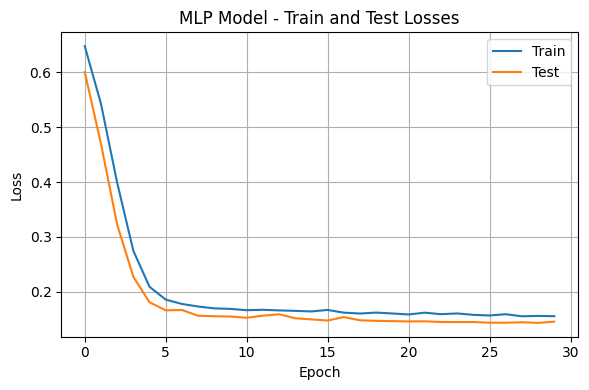

In [79]:
# Evaluating MLP Model
## Plot loss graph
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"MLP Model - Train and Test Losses")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()



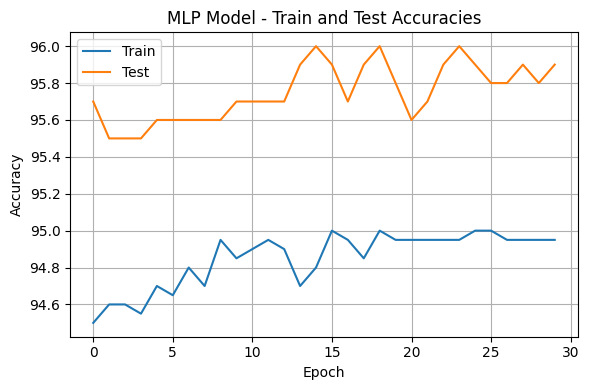

In [80]:
## Plot accuracy graph
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label="Train")
plt.plot(test_accuracies, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"MLP Model - Train and Test Accuracies")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()